In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import sys, os
import tqdm
import seaborn as sns
import scipy
from cycler import cycler
from itertools import repeat
import torch
from sklearn.decomposition import PCA

import subprocess
import stork.utils as utils
from scipy.sparse import *
from scipy.io import mmread

In [2]:
input_group_size = 100
duration     = 100.0
dt           = 1e-4
bin_duration = 25e-3
nb_inputs    = 500
nb_units     = 100
current_directory = os.getcwd()
output_path = os.path.join(current_directory, "plt")

In [3]:
colors = ['gray', '#81226A', '#81226A', '#058585', '#058585']
alphas = [1., 1., 0.5, 1., 0.5]

In [4]:
def densetoras(input_):
    row_indices, col_indices = np.where(input_)
    row_indices = row_indices * dt
    index_pairs = list(zip(row_indices, col_indices))
    return np.array(index_pairs)

In [5]:
from sklearn import linear_model
from sklearn.metrics import r2_score

def split_dataset(dataset, split=0.8, shuffle=False):
    x,y = dataset
    n = len(x)
    s = int(split*n)
    idx = np.arange(len(x))
    if shuffle: np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    x_train = x[:s]
    x_valid = x[s:]
    y_train = y[:s]
    y_valid = y[s:]
    return (x_train, y_train),(x_valid, y_valid)

In [6]:
def get_binned_data(input_spikes, exc_spikes):
    # Bin data ...
    binned_hidden = np.zeros((int(exc_spikes.shape[0]*dt/bin_duration), nb_units))
    for i in range(exc_spikes.shape[0]):
        idx = int(i*dt//bin_duration)
        flag = (exc_spikes[i] == 1.0)
        binned_hidden[idx][flag] += 1.0
    
    binned_input = np.zeros((int(input_spikes.shape[0]*dt/bin_duration), nb_inputs // input_group_size))
    for i in range(input_spikes.shape[0]):
        idx = int(i*dt//bin_duration)
        flag = (input_spikes[i] == 1.0)
        for j in range(flag.shape[0]):
            if flag[j]:
                binned_input[idx, j // input_group_size] += 1.0
    
    return binned_hidden,binned_input

In [7]:
def get_r2_values(input_spikes, exc_spikes, test_split=0.05, return_test_r2=False):
    
    # Prepare dataset for Lasso
    X,Y = get_binned_data(input_spikes, exc_spikes)
    
    res = []
    for g in range(5):
        dataset = (X,Y[:,g])
        ds_train, ds_test = split_dataset(dataset,split=1.0-test_split)

        lasso = linear_model.Lasso(alpha=0.1)
        lasso.fit(*ds_train)

        y_pred_lasso = lasso.predict(ds_test[0])
        r2_score_lasso = r2_score(ds_test[1], y_pred_lasso)
        res.append(r2_score_lasso)

    dataset = (X,Y)
    ds_train, ds_test = split_dataset(dataset, split=1.0-test_split)

    lasso = linear_model.Lasso(alpha=0.1)
    lasso.fit(*ds_train)

    y_pred_lasso = lasso.predict(ds_test[0])
    r2_score_lasso = r2_score(ds_test[1], y_pred_lasso)
   
    if return_test_r2:
        return res, r2_score_lasso
    else:
        return res

In [8]:
def participation_ratio(x):
    """
    Calculates participation ratio of the correlation matrix of the input
    pr = (sum of eigenvalues)^2 / sum of (eigenvalues^2)
    :param x: input feature array (batch x features)
    :return: ndarray
             participation ratio (singleton tensor)
    """
    x_c = x - x.mean(axis=0)

    corr_matrix = np.einsum('ij,kj->ik', x_c, x_c)

    eig_vals, _ = np.linalg.eig(corr_matrix)
    eig_vals = eig_vals.real

    pr = eig_vals.sum() ** 2 / (eig_vals ** 2).sum()

    return pr

In [9]:
def bin_weights_per_input_group(w_mat, nb_inputs=500, nb_groups=5):
    nb_elements_per_group = nb_inputs//nb_groups
    idxs = np.array([nb_elements_per_group*(i+1) for i in range(nb_groups)]) - 1

    sums = np.insert(np.cumsum(w_mat, axis=0)[idxs], 0, 0, axis=0)
    slice_means = (sums[1:]-sums[:-1])/nb_elements_per_group

    return slice_means

In [10]:
def analyze(input_spikes, exc_spikes, inh_spikes, outputdir, runid, nb_inputs=500, nb_units=100, test_split=0.05, t_start=None, inh=False, quiet=False):

    """
    This function analyzes neural spike data using Lasso regression and visualizes the results.

    Parameters:
    input_spikes (array): The spike data from input neurons.
    exc_spikes (array): The spike data from excitatory neurons.
    inh_spikes (array): The spike data from inhibitory neurons.
    outputdir (str): The directory to save the output figures.
    runid (str): The identifier for the current run.
    nb_inputs (int): The number of input neurons.
    nb_units (int): The number of excitatory neurons.
    test_split (float): The fraction of data to be used for testing.
    t_start (int): The start time for analysis.
    inh (bool): Whether to include inhibitory neurons in the analysis.

    """
    
    X, Y = get_binned_data(input_spikes, exc_spikes)

    res = []
    for g in range(5):
        dataset = (X,Y[:,g])
        ds_train, ds_test = split_dataset(dataset,split=1.0-test_split)

        lasso = linear_model.Lasso(alpha=0.1)
        lasso.fit(*ds_train)

        y_pred_lasso = lasso.predict(ds_test[0])
        r2_score_lasso = r2_score(ds_test[1], y_pred_lasso)
        if not quiet:
            print("r2 on test %i data : %f" %(g, r2_score_lasso))
        res.append(r2_score_lasso)
        
    dataset = (X,Y)
    ds_train, ds_test = split_dataset(dataset, split=1.0-test_split)

    lasso = linear_model.Lasso(alpha=0.1)
    lasso.fit(*ds_train)

    y_pred_lasso = lasso.predict(ds_test[0])
    r2_score_lasso = r2_score(ds_test[1], y_pred_lasso)
    if not quiet:
        print("r2 on test data : %f" %(r2_score_lasso))
        
    # print("Plotting data ...")
    marker_size = 0.8
    lw = 0.5
    alpha = 0.7
    t_start = int((duration * (1 - test_split))/dt)
    t_dur = duration * test_split
    fig = plt.figure(figsize=(4.2,3), dpi=150)
    gs = GridSpec(2,3, width_ratios=[2,1,0.3])
    
    plt.subplot(gs[0])
    plt.title("Input spikes", fontsize=10)
    ar = densetoras(input_spikes[t_start:])
    plt.scatter(ar[:,0], ar[:,1], marker='|', s=marker_size, alpha=0.4, c='black', linewidths=lw)
    plt.xlim((0, t_dur))
    plt.ylim((0, nb_inputs))
    plt.ylabel('Input spikes', fontsize=8)
    plt.axis("off")
    
    offset = 50
    offs = np.arange(5)*offset
    plt.subplot(gs[1])
    for i in range(5):
        plt.plot(ds_test[1][:,i]+offs[i], color=colors[i], alpha=alphas[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Binned input')
    plt.title("Input signals", fontsize=10)
    plt.ylim((0,5*offset))
    plt.axis("off")
   
    
    plt.subplot(gs[3])

    ar = []
    if len(inh_spikes):
        ar = densetoras(inh_spikes[t_start:])
    if len(ar):
        plt.scatter(ar[:,0], ar[:,1], marker='|', s=marker_size, alpha=alpha, c='#020072', linewidths=lw)
        
    ar = densetoras(exc_spikes[t_start:])
    if len(ar):
        plt.scatter(ar[:,0], 30 + ar[:,1], marker='|', s=marker_size, alpha=alpha, c='black', linewidths=lw)
    plt.xlim((0,t_dur)) 
    # plt.ylim((,100))
    plt.title("Network activity", fontsize=10)
    plt.ylabel('Neurons')
    plt.axis("off")
    
    

    plt.subplot(gs[4])    
    plt.title("Reconstruction", fontsize=10)
    for i in range(5):
        plt.plot(y_pred_lasso[:,i]+offs[i], color=colors[i], alpha=alphas[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Reconstruction')
    plt.ylim((0,5*offset))
    plt.axis("off")
    
    
    ax = plt.subplot(gs[5])  
    y_pos = np.arange(5)
    ax.barh(y_pos, res, color="gray", align="center")
    ax.set_yticks([])
    # ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('$R^2$', fontsize=10, labelpad=-1)
    ax.set_xlim((0,1.0))
    
    sns.despine()
    plt.tight_layout()
         

    plt.savefig("%s/%s_fig.png"%(outputdir,runid))
    plt.savefig("%s/%s_fig.pdf"%(outputdir,runid))
    # plt.close(fig)
    # r2_score_lasso = r2_score(ds_test[1], y_pred_lasso)
    C = np.corrcoef(y_pred_lasso.ravel(), ds_test[1].ravel())
    corr = C[0,1]
    print("IO correlation %f"%corr)
    return res



# Analyze

r2 on test 0 data : -0.027164
r2 on test 1 data : 0.796227
r2 on test 2 data : -0.000002
r2 on test 3 data : 0.830246
r2 on test 4 data : -0.003059
r2 on test data : 0.319250
IO correlation 0.737486


[-0.02716410453077489,
 0.7962270244876156,
 -1.9756092288769622e-06,
 0.8302461809416044,
 -0.003059363127001502]

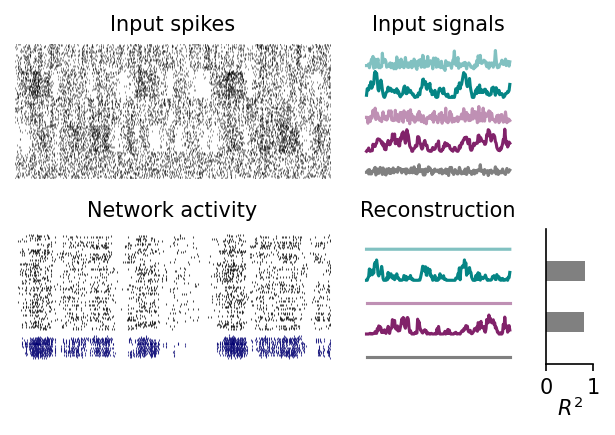

In [11]:
# LPL
filename_lpl = "50000s_LPL"
out_lpl = utils.load_from_file("outs/out_" + filename_lpl)
weight_lpl =  utils.load_from_file("outs/weight_" + filename_lpl)

input_spikes_lpl = out_lpl["input"]
input_spikes_lpl = torch.stack(input_spikes_lpl, dim=0)
input_spikes_lpl = input_spikes_lpl.reshape(input_spikes_lpl.shape[0], input_spikes_lpl.shape[2])

exc_spikes_lpl = out_lpl["exc"]
exc_spikes_lpl = torch.stack(exc_spikes_lpl, dim=0)
exc_spikes_lpl = exc_spikes_lpl.reshape(exc_spikes_lpl.shape[0], exc_spikes_lpl.shape[2])

inh_spikes_lpl = out_lpl["inh"]
inh_spikes_lpl = torch.stack(inh_spikes_lpl, dim=0)
inh_spikes_lpl = inh_spikes_lpl.reshape(inh_spikes_lpl.shape[0], inh_spikes_lpl.shape[2])

wmat_lpl = weight_lpl["LPLCon"]
wmat_lpl = wmat_lpl[0].T.numpy()

analyze(input_spikes_lpl, exc_spikes_lpl, inh_spikes_lpl, outputdir=output_path, runid=filename_lpl)

r2 on test 0 data : -0.027810
r2 on test 1 data : 0.354598
r2 on test 2 data : 0.099840
r2 on test 3 data : 0.353790
r2 on test 4 data : 0.072757
r2 on test data : 0.170635
IO correlation 0.520816


[-0.027809892263267688,
 0.3545979557178325,
 0.09983984803775292,
 0.3537895173588399,
 0.07275688375727773]

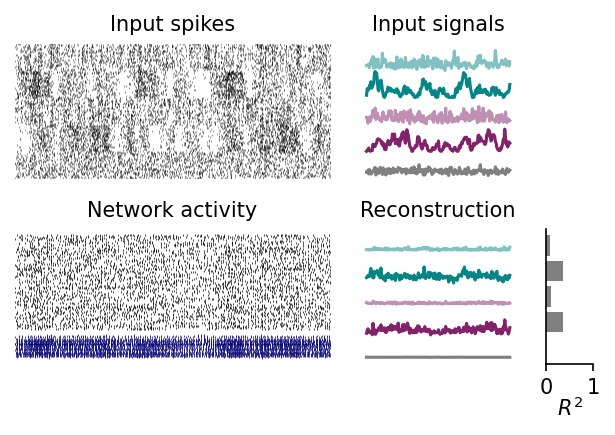

In [12]:
# pred off
filename_pred_off = "50000s_Pred_off"
out_pred_off = utils.load_from_file("outs/out_" + filename_pred_off)
weight_pred_off =  utils.load_from_file("outs/weight_" + filename_pred_off)

input_spikes_pred_off = out_pred_off["input"]
input_spikes_pred_off = torch.stack(input_spikes_pred_off, dim=0)
input_spikes_pred_off = input_spikes_pred_off.reshape(input_spikes_pred_off.shape[0], input_spikes_pred_off.shape[2])

exc_spikes_pred_off = out_pred_off["exc"]
exc_spikes_pred_off = torch.stack(exc_spikes_pred_off, dim=0)
exc_spikes_pred_off = exc_spikes_pred_off.reshape(exc_spikes_pred_off.shape[0], exc_spikes_pred_off.shape[2])

inh_spikes_pred_off = out_pred_off["inh"]
inh_spikes_pred_off = torch.stack(inh_spikes_pred_off, dim=0)
inh_spikes_pred_off = inh_spikes_pred_off.reshape(inh_spikes_pred_off.shape[0], inh_spikes_pred_off.shape[2])

wmat_pred_off = weight_pred_off["LPLCon"]
wmat_pred_off = wmat_pred_off[0].T.numpy()   

analyze(input_spikes_pred_off, exc_spikes_pred_off, inh_spikes_pred_off, outputdir=output_path, runid=filename_pred_off)

r2 on test 0 data : -0.027164
r2 on test 1 data : -0.008839
r2 on test 2 data : -0.000002
r2 on test 3 data : -0.002339
r2 on test 4 data : -0.003547
r2 on test data : -0.008378
IO correlation 0.003566


[-0.02716410453077489,
 -0.008838518332261458,
 -1.9756092288769622e-06,
 -0.002338857516483328,
 -0.003547412289453211]

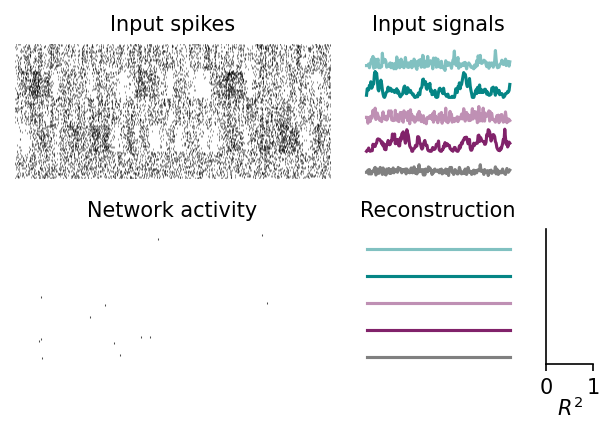

In [14]:
# hebb off
filename_hebb_off = "50000s_Hebb_off"
out_hebb_off = utils.load_from_file("outs/out_" + filename_hebb_off)
weight_heb_off =  utils.load_from_file("outs/weight_" + filename_hebb_off)

input_spikes_hebb_off = out_hebb_off["input"]
input_spikes_hebb_off = torch.stack(input_spikes_hebb_off, dim=0)
input_spikes_hebb_off = input_spikes_hebb_off.reshape(input_spikes_hebb_off.shape[0], input_spikes_hebb_off.shape[2])

exc_spikes_hebb_off = out_hebb_off["exc"]
exc_spikes_hebb_off = torch.stack(exc_spikes_hebb_off, dim=0)
exc_spikes_hebb_off = exc_spikes_hebb_off.reshape(exc_spikes_hebb_off.shape[0], exc_spikes_hebb_off.shape[2])

inh_spikes_hebb_off = out_hebb_off["inh"]
inh_spikes_hebb_off = torch.stack(inh_spikes_hebb_off, dim=0)
inh_spikes_hebb_off = inh_spikes_hebb_off.reshape(inh_spikes_hebb_off.shape[0], inh_spikes_hebb_off.shape[2])

wmat_hebb_off = weight_heb_off["LPLCon"]
wmat_hebb_off = wmat_hebb_off[0].T.numpy()

analyze(input_spikes_hebb_off, exc_spikes_hebb_off, [],outputdir=output_path, runid=filename_hebb_off, inh=False)


r2 on test 0 data : -0.015503
r2 on test 1 data : 0.665039
r2 on test 2 data : 0.093248
r2 on test 3 data : 0.772085
r2 on test 4 data : 0.110113
r2 on test data : 0.324996
IO correlation 0.713741


[-0.015503183966499634,
 0.6650390488329777,
 0.0932480156774439,
 0.7720846613328333,
 0.11011341313107625]

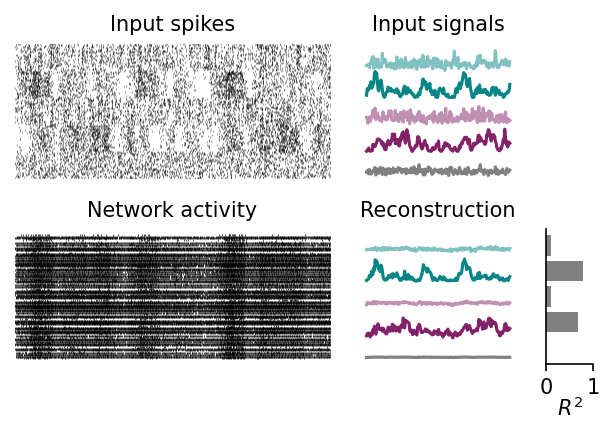

In [15]:
# inhib_off
filename_inhib_off = "50000s_Inhib_off"
out_inhib_off = utils.load_from_file("outs/out_" + filename_inhib_off)
weight_inhib_off =  utils.load_from_file("outs/weight_" + filename_inhib_off)

input_spikes_inhib_off = out_inhib_off["input"]
input_spikes_inhib_off = torch.stack(input_spikes_inhib_off, dim=0)
input_spikes_inhib_off = input_spikes_inhib_off.reshape(input_spikes_inhib_off.shape[0], input_spikes_inhib_off.shape[2])

exc_spikes_inhib_off = out_inhib_off["exc"]
exc_spikes_inhib_off = torch.stack(exc_spikes_inhib_off, dim=0)
exc_spikes_inhib_off = exc_spikes_inhib_off.reshape(exc_spikes_inhib_off.shape[0], exc_spikes_inhib_off.shape[2])

inh_spikes_inhib_off = []

wmat_inhib_off = weight_inhib_off["LPLCon"]
wmat_inhib_off = wmat_inhib_off[0].T.numpy()

analyze(input_spikes_inhib_off, exc_spikes_inhib_off, inh_spikes_inhib_off, outputdir=output_path, runid=filename_inhib_off)

r2 on test 0 data : 0.005685
r2 on test 1 data : 0.532012
r2 on test 2 data : 0.206931
r2 on test 3 data : 0.571345
r2 on test 4 data : 0.253509
r2 on test data : 0.313896
IO correlation 0.671689


[0.005685387870138281,
 0.5320119333226931,
 0.2069309212408743,
 0.5713446615119581,
 0.25350924064601754]

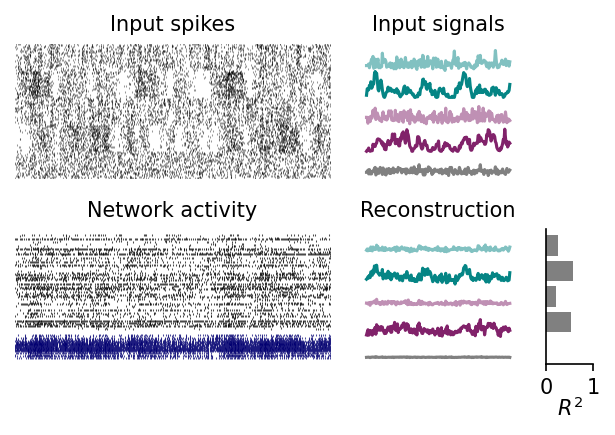

In [16]:
# inhib_fixed
filename_inhib_fixed = "25000s_Inhib_fixed"
out_inhib_fixed = utils.load_from_file("outs/out_" + filename_inhib_fixed)
weight_inhib_fixed =  utils.load_from_file("outs/weight_" + filename_inhib_fixed)

input_spikes_inhib_fixed = out_inhib_fixed["input"]
input_spikes_inhib_fixed = torch.stack(input_spikes_inhib_fixed, dim=0)
input_spikes_inhib_fixed = input_spikes_inhib_fixed.reshape(input_spikes_inhib_fixed.shape[0], input_spikes_inhib_fixed.shape[2])

exc_spikes_inhib_fixed = out_inhib_fixed["exc"]
exc_spikes_inhib_fixed = torch.stack(exc_spikes_inhib_fixed, dim=0)
exc_spikes_inhib_fixed = exc_spikes_inhib_fixed.reshape(exc_spikes_inhib_fixed.shape[0], exc_spikes_inhib_fixed.shape[2])

inh_spikes_inhib_fixed = out_inhib_fixed["inh"]
inh_spikes_inhib_fixed = torch.stack(inh_spikes_inhib_fixed, dim=0)
inh_spikes_inhib_fixed = inh_spikes_inhib_fixed.reshape(inh_spikes_inhib_fixed.shape[0], inh_spikes_inhib_fixed.shape[2])

wmat_inhib_fixed = weight_inhib_fixed["LPLCon"]
wmat_inhib_fixed = wmat_inhib_fixed[0].T.numpy()

analyze(input_spikes_inhib_fixed, exc_spikes_inhib_fixed, inh_spikes_inhib_fixed, outputdir=output_path, runid=filename_inhib_fixed)

## Extract some useful statistics

In [17]:
def read_results(input_spikes, exc_spikes, w_mat):

    # rates = aust.rates(exc_spikes)
    rates = np.zeros(nb_units)
    for spike in densetoras(exc_spikes):
        rates[int(spike[1])] += 1
    rates /= 100.

    X,Y = get_binned_data(input_spikes, exc_spikes)
    pr = participation_ratio(X)

    w_mat = bin_weights_per_input_group(w_mat)
    
    corrs = np.zeros(5)
    for j in range(5):
        corrs[j] = np.corrcoef(X.ravel(), Y[:,j].repeat(100).ravel())[0,1]

    return rates, pr, w_mat, corrs

# def relative_vals(vals, i, j):
#     return (vals[:,i]-vals[:,j])/(vals[:,i]+vals[:,j] + 1e-9)
def relative_vals(vals, i, j):
    return (vals[i,:]-vals[j,:])/(vals[i,:]+vals[j,:] + 1e-9)

In [18]:
# LPL
rates_lpl, dim_lpl, weights_lpl, corrs_lpl = read_results(input_spikes_lpl, exc_spikes_lpl, wmat_lpl)

# pred_off
rates_pred_off, dim_pred_off, weights_pred_off, corrs_pred_off = read_results(input_spikes_pred_off, exc_spikes_pred_off, wmat_pred_off)

# hebb_off
rates_hebb_off, dim_hebb_off, weights_hebb_off, corrs_hebb_off = read_results(input_spikes_hebb_off, exc_spikes_hebb_off, wmat_hebb_off)

# inhib_off
rates_inhib_off, dim_inhib_off, weights_inhib_off, corrs_inhib_off = read_results(input_spikes_inhib_off, exc_spikes_inhib_off, wmat_inhib_off)

# inhib_fixed
rates_inhib_fixed, dim_inhib_fixed, weights_inhib_fixed, corrs_inhib_fixed = read_results(input_spikes_inhib_fixed, exc_spikes_inhib_fixed, wmat_inhib_fixed)

## Panels spiking figure

In [19]:
slow_signal_index = 3 #
slow_shuffled_index = 4

fast_signal_index = 1
fast_shuffled_index = 2

control_index = 0

In [20]:
plt.figure(figsize=(1.9, 1.), dpi=300)
barWidth = 0.35

r1 = np.arange(5)
r2 = [x + barWidth for x in r1]
offsets = (2*np.random.random(100)-1)/10.
dotsize = 1

# LPL  
selectivity_slow_lpl = relative_vals(weights_lpl, slow_signal_index, slow_shuffled_index)
selectivity_fast_lpl = relative_vals(weights_lpl, fast_signal_index, fast_shuffled_index)

# Pred. off
selectivity_slow_pred_off = relative_vals(weights_pred_off, slow_signal_index, slow_shuffled_index)
selectivity_fast_pred_off = relative_vals(weights_pred_off, fast_signal_index, fast_shuffled_index)

# Hebb off
selectivity_slow_hebb_off = relative_vals(weights_hebb_off, slow_signal_index, slow_shuffled_index)
selectivity_fast_hebb_off = relative_vals(weights_hebb_off, fast_signal_index, fast_shuffled_index)

# Inhib. off
selectivity_slow_inhib_off = relative_vals(weights_inhib_off, slow_signal_index, slow_shuffled_index)
selectivity_fast_inhib_off = relative_vals(weights_inhib_off, fast_signal_index, fast_shuffled_index)

# Fixed inhib.
selectivity_slow_inhib_fixed = relative_vals(weights_inhib_fixed, slow_signal_index, slow_shuffled_index)
selectivity_fast_inhib_fixed = relative_vals(weights_inhib_fixed, fast_signal_index, fast_shuffled_index)

<Figure size 570x300 with 0 Axes>

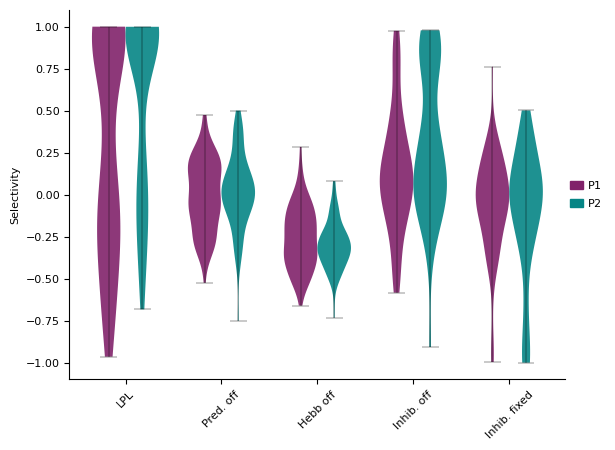

In [21]:
violin_parts = plt.violinplot(np.array([selectivity_fast_lpl, selectivity_fast_pred_off, selectivity_fast_hebb_off, selectivity_fast_inhib_off, selectivity_fast_inhib_fixed]).squeeze().T, positions=r1, widths=barWidth)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[fast_signal_index])
    pc.set_alpha(0.9)

violin_parts['cbars'].set_color('black')
violin_parts['cbars'].set_linewidth(0.3)
violin_parts['cmins'].set_color('black')
violin_parts['cmins'].set_linewidth(0.3)
violin_parts['cmaxes'].set_color('black')
violin_parts['cmaxes'].set_linewidth(0.3)

patch_1 = mpatches.Patch(color=colors[fast_signal_index])
fake_handle_1 = repeat(patch_1, 1)




violin_parts = plt.violinplot(np.array([selectivity_slow_lpl, selectivity_slow_pred_off, selectivity_slow_hebb_off, selectivity_slow_inhib_off, selectivity_slow_inhib_fixed]).squeeze().T, positions=r2, widths=barWidth)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[slow_signal_index])
    pc.set_alpha(0.9)

violin_parts['cbars'].set_color('black')
violin_parts['cbars'].set_linewidth(0.3)
violin_parts['cmins'].set_color('black')
violin_parts['cmins'].set_linewidth(0.3)
violin_parts['cmaxes'].set_color('black')
violin_parts['cmaxes'].set_linewidth(0.3)

patch_2 = mpatches.Patch(color=colors[slow_signal_index])
fake_handle_2 = repeat(patch_2, 1)

handles = [patch_1, patch_2]
labels = ['P$1$', 'P$2$']
lgd = plt.legend(handles, labels, frameon=False, fontsize=8, loc=(1., 0.45), handlelength=1.2, handletextpad=0.3)

# plt.bar(r2, [selectivity_slow.mean(), selectivity_slow_pred_off.mean(), selectivity_slow_hebb_off.mean(), selectivity_slow_inhib_off.mean(), selectivity_slow_fixed_inhib.mean()], color=colors[slow_signal_index], width = barWidth, label='$P2$', capsize=2)

plt.ylabel('Selectivity', fontsize=8)
plt.xticks([r + 0.5*barWidth for r in range(len(r1))], ['LPL', 'Pred. off', 'Hebb off', 'Inhib. off', 'Inhib. fixed'], fontsize=8)
# lgd = plt.legend(frameon=False, fontsize=8, loc=(0.25, 0.5), handlelength=1.4)
plt.xticks(rotation=45, fontsize=8)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
# ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
# plt.yticks([0, 0.5])
sns.despine()
plt.savefig(os.path.join(output_path,'diff_slowness_selectivity.pdf'), bbox_inches='tight')

# Weight

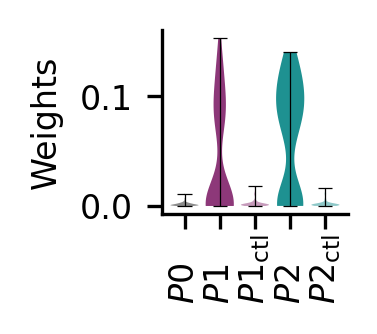

In [22]:
plt.figure(figsize=(0.8, 0.8), dpi=300)
# plt.figure(figsize=(0.9, 0.9), dpi=300)
violin_parts = plt.violinplot(weights_lpl.squeeze().T, np.arange(1,6), widths=0.8)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(alphas[i]*0.9)

violin_parts['cbars'].set_color('black')
violin_parts['cbars'].set_linewidth(0.3)
violin_parts['cmins'].set_color('black')
violin_parts['cmins'].set_linewidth(0.3)
violin_parts['cmaxes'].set_color('black')
violin_parts['cmaxes'].set_linewidth(0.3)

plt.ylabel('Weights', fontsize=8)
plt.xticks(np.arange(1,6), ['$P0$', '$P1$', '$P1_{\mathrm{ctl}}$', '$P2$', '$P2_{\mathrm{ctl}}$'], fontsize=8, rotation=90, va='bottom')
ax = plt.gca()
ax.tick_params(axis = 'y', which = 'major', labelsize=8)
ax.tick_params(axis="x", pad=18)
sns.despine()

plt.savefig(os.path.join(output_path,'diff_slowness_weights_lpl.pdf'), bbox_inches='tight')

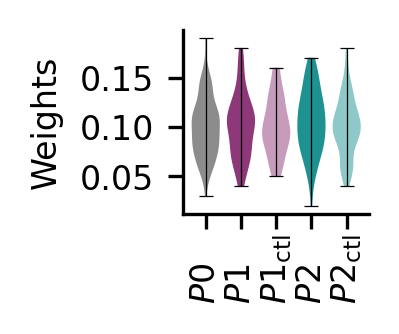

In [23]:
plt.figure(figsize=(0.8, 0.8), dpi=300)
# plt.figure(figsize=(0.9, 0.9), dpi=300)
violin_parts = plt.violinplot(weights_pred_off.squeeze().T, np.arange(1,6), widths=0.8)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(alphas[i]*0.9)

violin_parts['cbars'].set_color('black')
violin_parts['cbars'].set_linewidth(0.3)
violin_parts['cmins'].set_color('black')
violin_parts['cmins'].set_linewidth(0.3)
violin_parts['cmaxes'].set_color('black')
violin_parts['cmaxes'].set_linewidth(0.3)

plt.ylabel('Weights', fontsize=8)
plt.xticks(np.arange(1,6), ['$P0$', '$P1$', '$P1_{\mathrm{ctl}}$', '$P2$', '$P2_{\mathrm{ctl}}$'], fontsize=8, rotation=90, va='bottom')

ax = plt.gca()
ax.tick_params(axis = 'y', which = 'major', labelsize=8)
ax.tick_params(axis="x", pad=18)
sns.despine()

plt.savefig(os.path.join(output_path,'diff_slowness_weights_pred_off.pdf'), bbox_inches='tight')

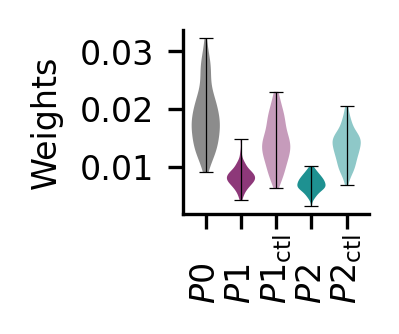

In [24]:
plt.figure(figsize=(0.8, 0.8), dpi=300)
# plt.figure(figsize=(0.9, 0.9), dpi=300)
violin_parts = plt.violinplot(weights_hebb_off.squeeze().T, np.arange(1,6), widths=0.8)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(alphas[i]*0.9)

violin_parts['cbars'].set_color('black')
violin_parts['cbars'].set_linewidth(0.3)
violin_parts['cmins'].set_color('black')
violin_parts['cmins'].set_linewidth(0.3)
violin_parts['cmaxes'].set_color('black')
violin_parts['cmaxes'].set_linewidth(0.3)

plt.ylabel('Weights', fontsize=8)
plt.xticks(np.arange(1,6), ['$P0$', '$P1$', '$P1_{\mathrm{ctl}}$', '$P2$', '$P2_{\mathrm{ctl}}$'], fontsize=8, rotation=90, va='bottom')
# plt.yticks([0, 0.05])
ax = plt.gca()
ax.tick_params(axis = 'y', which = 'major', labelsize=8)
ax.tick_params(axis="x", pad=18)
sns.despine()

plt.savefig(os.path.join(output_path,'diff_slowness_weights_hebb_off.pdf'), bbox_inches='tight')

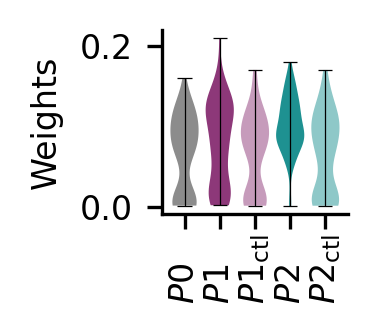

In [25]:
plt.figure(figsize=(0.8, 0.8), dpi=300)
# plt.figure(figsize=(0.9, 0.9), dpi=300)
violin_parts = plt.violinplot(weights_inhib_off.squeeze().T, np.arange(1,6), widths=0.8)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(alphas[i]*0.9)

violin_parts['cbars'].set_color('black')
violin_parts['cbars'].set_linewidth(0.3)
violin_parts['cmins'].set_color('black')
violin_parts['cmins'].set_linewidth(0.3)
violin_parts['cmaxes'].set_color('black')
violin_parts['cmaxes'].set_linewidth(0.3)

plt.ylabel('Weights', fontsize=8)
plt.xticks(np.arange(1,6), ['$P0$', '$P1$', '$P1_{\mathrm{ctl}}$', '$P2$', '$P2_{\mathrm{ctl}}$'], fontsize=8, rotation=90, va='bottom')
# plt.yticks([0, 0.05])
ax = plt.gca()
ax.tick_params(axis = 'y', which = 'major', labelsize=8)
ax.tick_params(axis="x", pad=18)
sns.despine()

plt.savefig(os.path.join(output_path,'diff_slowness_weights_inhib_off.pdf'), bbox_inches='tight')

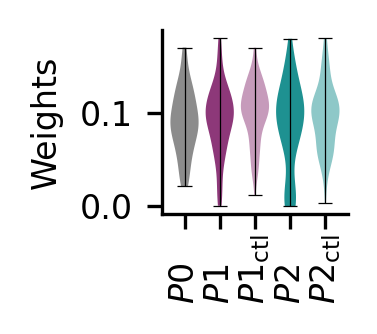

In [26]:
plt.figure(figsize=(0.8, 0.8), dpi=300)
# plt.figure(figsize=(0.9, 0.9), dpi=300)
violin_parts = plt.violinplot(weights_inhib_fixed.squeeze().T, np.arange(1,6), widths=0.8)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(alphas[i]*0.9)

violin_parts['cbars'].set_color('black')
violin_parts['cbars'].set_linewidth(0.3)
violin_parts['cmins'].set_color('black')
violin_parts['cmins'].set_linewidth(0.3)
violin_parts['cmaxes'].set_color('black')
violin_parts['cmaxes'].set_linewidth(0.3)

plt.ylabel('Weights', fontsize=8)
plt.xticks(np.arange(1,6), ['$P0$', '$P1$', '$P1_{\mathrm{ctl}}$', '$P2$', '$P2_{\mathrm{ctl}}$'], fontsize=8, rotation=90, va='bottom')
# plt.yticks([0, 0.05])
ax = plt.gca()
ax.tick_params(axis = 'y', which = 'major', labelsize=8)
ax.tick_params(axis="x", pad=18)
sns.despine()

plt.savefig(os.path.join(output_path,'diff_slowness_weights_inhib_fixed.pdf'), bbox_inches='tight')

# Activity

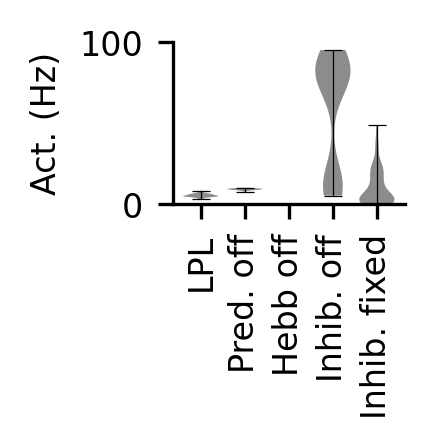

In [27]:
plt.figure(figsize=(1., 0.7), dpi=300)

barWidth = 0.55

r1 = np.arange(5)

violin_parts = plt.violinplot(np.array([rates_lpl, rates_pred_off, rates_hebb_off, rates_inhib_off, rates_inhib_fixed]).squeeze().T, np.arange(1,6), widths=0.8)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor('gray')
    pc.set_alpha(0.9)

violin_parts['cbars'].set_color('black')
violin_parts['cbars'].set_linewidth(0.3)
violin_parts['cmins'].set_color('black')
violin_parts['cmins'].set_linewidth(0.3)
violin_parts['cmaxes'].set_color('black')
violin_parts['cmaxes'].set_linewidth(0.3)

# plt.bar(r1, [rates_lpl[idx].mean(), rates_pred_off[idx].mean(), rates_lpl[hebb_off_idx].mean(), rates_ff[idx].mean(), rates_fixed_inhib[idx].mean()], color ='gray', width = barWidth, capsize=1.2, error_kw = {'elinewidth':0.5, 'capthick':0.5}, yerr=[rates_lpl[idx].std()/10, rates_pred_off[idx].std()/10, rates_lpl[hebb_off_idx].std()/10, rates_ff[idx].std()/10, rates_fixed_inhib[idx].std()/10])
# plt.bar(r1, [rates_lpl[idx].mean(), rates_pred_off[idx].mean(), rates_lpl[hebb_off_idx].mean(), rates_ff[idx].mean(), rates_fixed_inhib[idx].mean()], color ='gray', width = barWidth)
plt.xticks(r1+1, ['LPL', 'Pred. off', 'Hebb off', 'Inhib. off', 'Inhib. fixed'], fontsize=8)
plt.ylabel('Act. (Hz)', fontsize=8)
plt.xticks(rotation=90, fontsize=8)
plt.ylim(0, 100)  # Setting y-axis limit to 0 to 100
plt.yticks([0, 100], fontsize=8)  # Setting y-axis ticks
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
# ax.yaxis.set_major_formatter(FormatStrFormatter("%2d"))
# ax.set_yscale('log')
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
sns.despine()
plt.savefig(os.path.join(output_path,'diff_slowness_activity.pdf'), bbox_inches='tight')

## Dimension

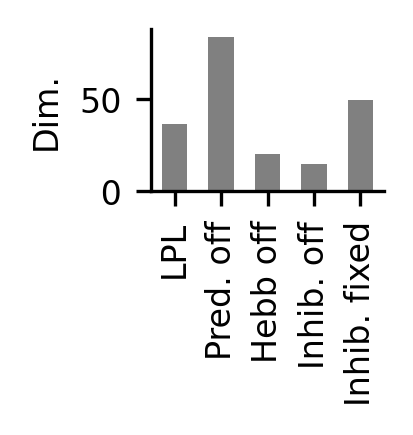

In [83]:
plt.figure(figsize=(1., 0.7), dpi=300)

barWidth = 0.55

r1 = np.arange(5)
r2 = [x + barWidth for x in r1]

plt.bar(r1, [dim_lpl, dim_pred_off, dim_hebb_off, dim_inhib_off, dim_inhib_fixed], color ='gray', width = barWidth, capsize=2)

plt.xticks(r1, ['LPL', 'Pred. off', 'Hebb off', 'Inhib. off', 'Inhib. fixed'], fontsize=8)
plt.ylabel('Dim.', fontsize=8)
plt.xticks(rotation=90, fontsize=8)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter("%2d"))
# ax.set_yscale('log')
sns.despine()
plt.savefig(os.path.join(output_path,'diff_slowness_dim.pdf'), bbox_inches='tight')

## Weight quivers

In [30]:
w_lpl = weights_lpl.squeeze()
w_pred_off = weights_pred_off.squeeze()
w_hebb_off = weights_hebb_off.squeeze()
w_ff = weights_inhib_off.squeeze()
w_fixed_inhib = weights_inhib_fixed.squeeze()

In [31]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

In [32]:
import matplotlib.colors as mcolors

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [33]:
def combine_hex_values(color_1, color_2, weights_1, weights_2):
    red = ((int(color_1[1:3], 16) * weights_1 + int(color_2[1:3], 16) * weights_2)/(weights_1 + weights_2 + 1e-9)).astype(int)
    green = ((int(color_1[3:5], 16) * weights_1 + int(color_2[3:5], 16) * weights_2)/(weights_1 + weights_2 + 1e-9)).astype(int)
    blue = ((int(color_1[5:7], 16) * weights_1 + int(color_2[5:7], 16) * weights_2)/(weights_1 + weights_2 + 1e-9)).astype(int)
    hex_codes = ['#%02x%02x%02x'%(r,g,b) for r,g,b in zip(red, green, blue)]
    return hex_codes

In [34]:
interp_colors = [colors[fast_signal_index], '#C0C0C0', colors[slow_signal_index]]
interp_values = [0, 0.5, 1]
divnorm = mcolors.TwoSlopeNorm(vmin=0, vcenter=np.pi/4, vmax=1)
cmap = get_continuous_cmap(interp_colors, interp_values)

In [35]:
def get_weighted_colors(weight_1, weight_2):
    angle = ((weight_1-weight_2)/(weight_1+weight_2+1e-9)+1)/2
    weighted_colors = cmap(angle)
    return weighted_colors

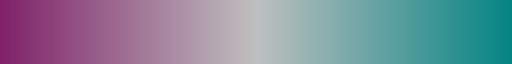

In [36]:
cmap

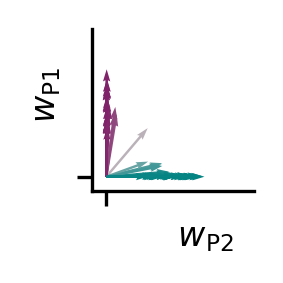

In [37]:
weighted_colors = get_weighted_colors(w_lpl[slow_signal_index], w_lpl[fast_signal_index])

x, y = np.meshgrid(np.zeros(10), np.zeros(10))
plt.figure(figsize=(0.7,0.7), dpi=300)
plt.quiver(x, y, w_lpl[slow_signal_index], w_lpl[fast_signal_index], angles='xy', scale_units='xy', scale=1., color=weighted_colors, width=0.015)
# plt.axline((0, 0), (0.2, 0.2), color='gray', linestyle='dashed', linewidth=1)
# plt.quiver(0, 0, w_lpl[slow_signal_index].mean(), w_lpl[fast_signal_index].mean(), angles='xy', scale_units='xy', scale=1., color='k', width=0.02)
plt.axis('square')
plt.xlim(-0.02,0.21)
plt.ylim(-0.02,0.21)
plt.xlabel('$\quad \quad w_{\mathrm{P2}}$', fontsize=8, labelpad=0)
plt.ylabel('$\quad w_{\mathrm{P1}}$', fontsize=8, labelpad=0)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
plt.yticks([0])
plt.xticks([0])
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.despine()
plt.savefig(os.path.join(output_path,'diff_slowness_wt_quiver_lpl.pdf'), bbox_inches='tight')

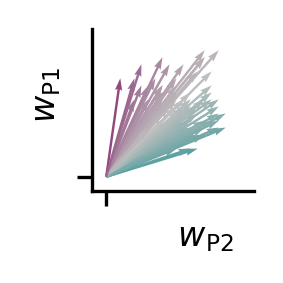

In [38]:
weighted_colors = get_weighted_colors(w_pred_off[slow_signal_index], w_pred_off[fast_signal_index])
plt.figure(figsize=(0.7,0.7), dpi=300)
plt.quiver(x, y, w_pred_off[slow_signal_index], w_pred_off[fast_signal_index], angles='xy', scale_units='xy', scale=1., color=weighted_colors, width=0.015)
# plt.axline((0, 0), (0.2, 0.2), color='gray', linestyle='dashed', linewidth=1)
# plt.quiver(0, 0, w_lpl[slow_signal_index].mean(), w_lpl[fast_signal_index].mean(), angles='xy', scale_units='xy', scale=1., color='k', width=0.02)
plt.axis('square')
plt.xlim(-0.02,0.21)
plt.ylim(-0.02,0.21)
plt.xlabel('$\quad \quad w_{\mathrm{P2}}$', fontsize=8, labelpad=0)
plt.ylabel('$\quad w_{\mathrm{P1}}$', fontsize=8, labelpad=0)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
plt.yticks([0])
plt.xticks([0])
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.despine()
plt.savefig(os.path.join(output_path,'diff_slowness_wt_quiver_pred_off.pdf'), bbox_inches='tight')

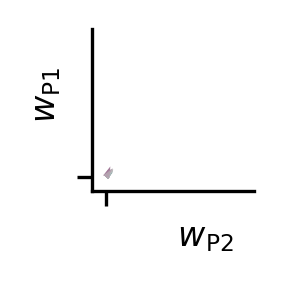

In [39]:
weighted_colors = get_weighted_colors(w_hebb_off[slow_signal_index], w_hebb_off[fast_signal_index])
plt.figure(figsize=(0.7,0.7), dpi=300)
plt.quiver(x, y, w_hebb_off[slow_signal_index], w_hebb_off[fast_signal_index], angles='xy', scale_units='xy', scale=1., color=weighted_colors, width=0.015)
# plt.axline((0, 0), (0.2, 0.2), color='gray', linestyle='dashed', linewidth=1)
# plt.quiver(0, 0, w_lpl[slow_signal_index].mean(), w_lpl[fast_signal_index].mean(), angles='xy', scale_units='xy', scale=1., color='k', width=0.02)
plt.axis('square')
plt.xlim(-0.02,0.21)
plt.ylim(-0.02,0.21)
plt.xlabel('$\quad \quad w_{\mathrm{P2}}$', fontsize=8, labelpad=0)
plt.ylabel('$\quad w_{\mathrm{P1}}$', fontsize=8, labelpad=0)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
plt.yticks([0])
plt.xticks([0])
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.despine()
plt.savefig(os.path.join(output_path,'diff_slowness_wt_quiver_hebb_off.pdf'), bbox_inches='tight')

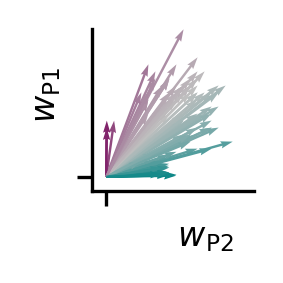

In [40]:
weighted_colors = get_weighted_colors(w_ff[slow_signal_index], w_ff[fast_signal_index])
plt.figure(figsize=(0.7,0.7), dpi=300)
plt.quiver(x, y, w_ff[slow_signal_index], w_ff[fast_signal_index], angles='xy', scale_units='xy', scale=1., color=weighted_colors, width=0.015)
# plt.axline((0, 0), (0.2, 0.2), color='gray', linestyle='dashed', linewidth=1)
# plt.quiver(0, 0, w_decorr_off[slow_signal_index].mean(), w_decorr_off[fast_signal_index].mean(), angles='xy', scale_units='xy', scale=1., color='k', width=0.02)
plt.axis('square')
plt.xlim(-0.02,0.21)
plt.ylim(-0.02,0.21)
plt.xlabel('$\quad \quad w_{\mathrm{P2}}$', fontsize=8, labelpad=0)
plt.ylabel('$\quad w_{\mathrm{P1}}$', fontsize=8, labelpad=0)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
plt.yticks([0])
plt.xticks([0])
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.despine()
plt.savefig(os.path.join(output_path,'diff_slowness_wt_quiver_inhib_off.pdf'), bbox_inches='tight')

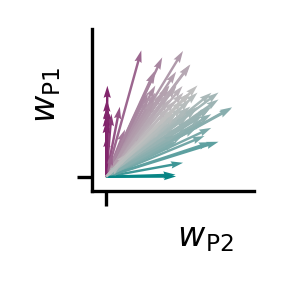

In [41]:
weighted_colors = get_weighted_colors(w_fixed_inhib[slow_signal_index], w_fixed_inhib[fast_signal_index])
plt.figure(figsize=(0.7,0.7), dpi=300)
plt.quiver(x, y, w_fixed_inhib[slow_signal_index], w_fixed_inhib[fast_signal_index], angles='xy', scale_units='xy', scale=1., color=weighted_colors, width=0.015)
# plt.axline((0, 0), (0.2, 0.2), color='gray', linestyle='dashed', linewidth=1)
# plt.quiver(0, 0, w_decorr_off[slow_signal_index].mean(), w_decorr_off[fast_signal_index].mean(), angles='xy', scale_units='xy', scale=1., color='k', width=0.02)
plt.axis('square')
plt.xlim(-0.02,0.21)
plt.ylim(-0.02,0.21)
plt.xlabel('$\quad \quad w_{\mathrm{P2}}$', fontsize=8, labelpad=0)
plt.ylabel('$\quad w_{\mathrm{P1}}$', fontsize=8, labelpad=0)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
plt.yticks([0])
plt.xticks([0])
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.despine()
plt.savefig(os.path.join(output_path,'diff_slowness_wt_quiver_inhib_fixed.pdf'), bbox_inches='tight')

## Relative selectivities

In [42]:
rel_selectivity_lpl = relative_vals(weights_lpl, slow_signal_index, fast_signal_index).squeeze()
rel_selectivity_pred_off = relative_vals(weights_pred_off, slow_signal_index, fast_signal_index).squeeze()
rel_selectivity_hebb_off = relative_vals(weights_hebb_off, slow_signal_index, fast_signal_index).squeeze()
rel_selectivity_inhib_off = relative_vals(weights_inhib_off, slow_signal_index, fast_signal_index).squeeze()
rel_selectivity_fixed_inhib = relative_vals(weights_inhib_fixed, slow_signal_index, fast_signal_index).squeeze()

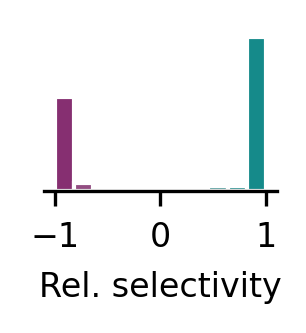

In [43]:
plt.figure(figsize=(1.,0.7), dpi=300)
N, bins, patches = plt.hist(rel_selectivity_lpl, bins=11, edgecolor='white', color='teal', density=True)
color_weights = (0.5*(bins[:-1]+bins[1:])+1)/2
weighted_colors = get_weighted_colors(color_weights, 1.-color_weights)
for i in range(len(N)):
    patches[i].set_facecolor(weighted_colors[i])
sns.despine()
# plt.ylim(0,40)
plt.xlabel('Rel. selectivity', fontsize=8)
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
# plt.title('LPL', fontsize=10)
plt.savefig(os.path.join(output_path,'diff_slowness_rel_sel_hist_lpl.pdf'), bbox_inches='tight')

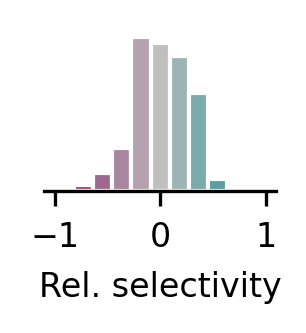

In [44]:
plt.figure(figsize=(1.,0.7), dpi=300)
N, bins, patches = plt.hist(rel_selectivity_pred_off, bins=11, edgecolor='white', color='teal', density=True, range=(-1,1))
color_weights = (0.5*(bins[:-1]+bins[1:])+1)/2
weighted_colors = get_weighted_colors(color_weights, 1.-color_weights)
for i in range(len(N)):
    patches[i].set_facecolor(weighted_colors[i])
sns.despine()
# plt.ylim(0,40)
plt.xlabel('Rel. selectivity', fontsize=8)
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
# plt.title('Pred. off', fontsize=10)
plt.savefig(os.path.join(output_path,'diff_slowness_rel_sel_hist_pred_off.pdf'), bbox_inches='tight')

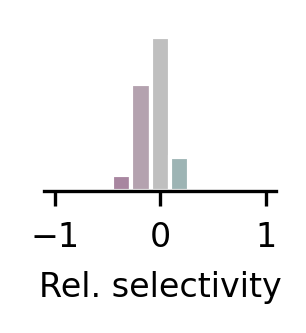

In [45]:
plt.figure(figsize=(1.,0.7), dpi=300)
N, bins, patches = plt.hist(rel_selectivity_hebb_off, bins=11, edgecolor='white', color='teal', density=True, range=(-1,1))
color_weights = (0.5*(bins[:-1]+bins[1:])+1)/2
weighted_colors = get_weighted_colors(color_weights, 1.-color_weights)
for i in range(len(N)):
    patches[i].set_facecolor(weighted_colors[i])
sns.despine()
# plt.ylim(0,40)
plt.xlabel('Rel. selectivity', fontsize=8)
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
# plt.title('Hebb off', fontsize=10)
plt.savefig(os.path.join(output_path,'diff_slowness_rel_sel_hist_hebb_off.pdf'), bbox_inches='tight')

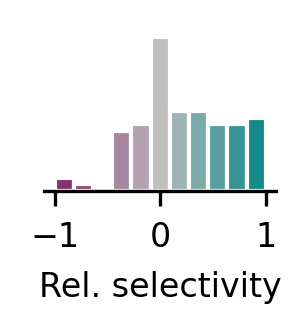

In [46]:
plt.figure(figsize=(1.,0.7), dpi=300)
N, bins, patches = plt.hist(rel_selectivity_inhib_off, bins=11, edgecolor='white', color='teal', density=True, range=(-1,1))
color_weights = (0.5*(bins[:-1]+bins[1:])+1)/2
weighted_colors = get_weighted_colors(color_weights, 1.-color_weights)
for i in range(len(N)):
    patches[i].set_facecolor(weighted_colors[i])
# plt.ylim(0,40)
sns.despine()
plt.xlabel('Rel. selectivity', fontsize=8)
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.tick_params(axis = 'x', which = 'major', labelsize=8)
# plt.title('Inhib. off', fontsize=10)
plt.savefig(os.path.join(output_path,'diff_slowness_rel_sel_hist_inhib_off.pdf'), bbox_inches='tight')

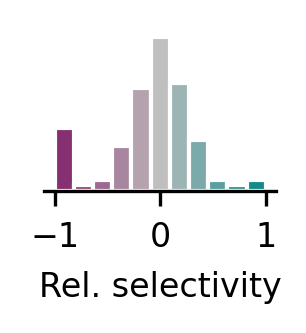

In [47]:
plt.figure(figsize=(1.,0.7), dpi=300)
N, bins, patches = plt.hist(rel_selectivity_fixed_inhib, bins=11, edgecolor='white', color='teal', density=True, range=(-1,1))
color_weights = (0.5*(bins[:-1]+bins[1:])+1)/2
weighted_colors = get_weighted_colors(color_weights, 1.-color_weights)
for i in range(len(N)):
    patches[i].set_facecolor(weighted_colors[i])
# plt.ylim(0,40)
sns.despine()
plt.xlabel('Rel. selectivity', fontsize=8)
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.tick_params(axis = 'x', which = 'major', labelsize=8)
# plt.title('Inhib. fixed', fontsize=10)
plt.savefig(os.path.join(output_path,'diff_slowness_rel_sel_hist_inhib_fixed.pdf'), bbox_inches='tight')